In [1]:
%pylab inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas.io.data as web
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# we modify this data organizing slightly to get two symbols
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T

def sort_data(rets):
    ins = []
    outs = []
    for i in range(len(rets)-100):
        ins.append(rets[i:i+100].tolist())
        outs.append(rets[i+100])
    return np.array(ins), np.array(outs)
        


In [3]:
symbol_list = ['C', 'GS']
rets = get_data(symbol_list)
ins, outs = sort_data(rets)
ins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])
div = int(.8 * ins.shape[0])
train_ins, train_outs = ins[:div], outs[:div]
test_ins, test_outs = ins[div:], outs[div:]

#normalize inputs
train_ins, test_ins = train_ins/np.std(ins), test_ins/np.std(ins)

In [4]:
sess = tf.InteractiveSession()

In [93]:
positions = tf.constant([-1,0,1]) #long, neutral or short
num_positions = 3

# define placeholders 
x = tf.placeholder(tf.float32, [None, len(symbol_list) * 100])
y_ = tf.placeholder(tf.float32, [None,  len(symbol_list)])

# define trainable variables
W = tf.Variable(tf.random_normal([len(symbol_list) * 100, num_positions * len(symbol_list)]))
b = tf.Variable(tf.random_normal([num_positions * len(symbol_list)]))

# we define our model: y = W*x + b
y = tf.matmul(x, W) + b # y is tensor of shape [num_inputs, num_positions * len(symbol_list)]
# a row of y will look like [prob_symbol_1_short, prob_symbol_1_neutral, prob_symbol_1_long, prob_symbol_2_short, ...]
# note that they are not really probabilities because I did not perform a softmax yet


# loop through symbol, taking the columns for each symbol's bucket together
pos = {}
symbol_returns = {}
relevant_target_column = {}
for i in range(len(symbol_list)):
    # isolate the buckets relevant to the symbol and get a softmax as well
    symbol_probs = y[:,i*num_positions:(i+1)*num_positions]
    symbol_probs_softmax = tf.nn.softmax(symbol_probs) # softmax[i, j] = exp(logits[i, j]) / sum(exp(logits[i]))
    # sample probability to chose our policy's action
    sample = tf.multinomial(tf.log(symbol_probs_softmax), 1)#sample = tf.argmax(symbol_probs_softmax, 1) #use a real sample
    pos[i] = tf.reshape(sample, [-1]) - 1   # choose(-1,0,1)
    # get returns by multiplying the policy (position taken) by the target return for that day
    symbol_returns[i] = tf.mul(tf.cast(pos[i], float32),  y_[:,i])
    # isolate the probability of the selected policy (for use in calculating gradient)
        #relevant_target_column[i] = tf.reduce_max(symbol_probs,1) # should be relevant to SAMPLE
    #relevant_target_column[i] = tf.gather_nd(symbol_probs, tf.reshape(sample, [-1,1]))
    #relevant_target_column[i] = symbol_probs[:,sample]
    sample_mask = tf.reshape(tf.one_hot(sample, 3), [-1,3])
    relevant_target_column[i] = tf.reduce_sum(symbol_probs * sample_mask,1)#tf.boolean_mask(symbol_probs, tf.reshape(sample_mask, [-1,3]))
    
    
    #sample_flattened = tf.range(0, symbol_probs.get_shape()[0]) * symbol_probs.shape[1] + sample
    #y = tf.gather(tf.reshape(symbol_probs, [-1]),  # flatten input
    #          sample_flattened)
    
print(sample)
print(sample_mask)
print(symbol_probs)
print(relevant_target_column[0])
# calculate the performance metrics for the data chosen
daily_returns_by_symbol = tf.concat(1, [tf.reshape(t, [-1,1]) for t in symbol_returns.values()])
daily_returns = tf.reduce_sum(daily_returns_by_symbol,1)/2
total_return = tf.reduce_prod(daily_returns + 1)
ann_vol = tf.mul(
    tf.sqrt(tf.reduce_mean(tf.pow((daily_returns - tf.reduce_mean(daily_returns)),2))) ,
    np.sqrt(252)
    )
sharpe = total_return / ann_vol

# since we only train the sampled classes, we will combine them so that we can feed them into cross entropy
training_target_cols = tf.concat(1, [tf.reshape(t, [-1,1]) for t in relevant_target_column.values()])
# we want to either push the gradient toward our selection or away from it. We use these ones to find the direction
#     of the gradient, which we will then multiply by our fitness function
ones = tf.ones_like(training_target_cols)

# this isnt actuall a gradient, but karpathy sort of calls it one. Since it is a tensor it sort of is a gradient anyway
gradient = tf.nn.sigmoid_cross_entropy_with_logits(training_target_cols, ones) ####should this be a prob???

print(daily_returns)
# how should we do this step? it depends how we want to group our results. Choose your own adventure here by uncommenting a cost fn
# this is the most obvious: we push each weight to what works or not. Try it out...we're gonna be RICH!!!! oh, wait...
#cost = tf.mul(gradient , daily_returns_by_symbol)
# this takes the overall daily return and pushes the weights so that the overall day wins. Again, it overfits enormously
cost = tf.mul(gradient , tf.reshape(daily_returns,[-1,1]))
# this multiplies every gradient by the overall return. If the strategy won for the past ten years, we do more of it and vice versa
#cost = tf.mul(gradient , total_return)

# minimize the cost (push the weights where we want them to go)
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cost)

Tensor("multinomial_48/Multinomial:0", shape=(?, 1), dtype=int64)
Tensor("Reshape_116:0", shape=(?, 3), dtype=float32)
Tensor("Slice_140:0", shape=(?, 3), dtype=float32)
Tensor("Sum_35:0", shape=(?,), dtype=float32)
Tensor("truediv_43:0", shape=(?,), dtype=float32)


In [99]:
# initialize variables to random values
init = tf.initialize_all_variables()
sess.run(init)
# run optimizer on entire training data set many times
for epoch in range(5000):
    sess.run(optimizer, feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
    # every 1000 iterations record progress
    if (epoch+1)%1000== 0:
        c,t = sess.run([cost, total_return], feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(t), "total return=", "{:.9f}".format(t-1))

Epoch: 1000 cost= 502.030090332 total return= 501.030090332
Epoch: 2000 cost= 544.416931152 total return= 543.416931152
Epoch: 3000 cost= 220.474853516 total return= 219.474853516
Epoch: 4000 cost= 272.573730469 total return= 271.573730469
Epoch: 5000 cost= 388.628082275 total return= 387.628082275


In [100]:
# in sample results
d, t = sess.run([daily_returns, gradient], feed_dict={x: train_ins, y_: train_outs})

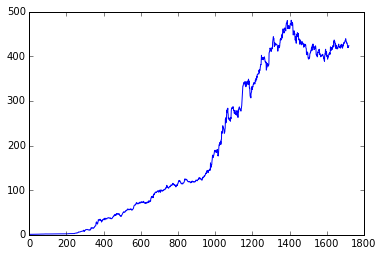

In [101]:
# equity curve
plot(np.cumprod(d+1))

In [102]:
#out of sample results
d, t = sess.run([daily_returns, gradient], feed_dict={x: test_ins, y_: test_outs})

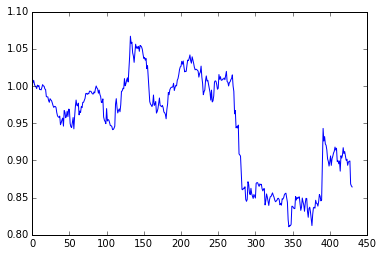

In [103]:
#out of sample results
plot(np.cumprod(d+1))